In [ ]:
###
    # This code plot the permafrost loss at depths of 1.6 m, 2.4 m, and 3.2 m, 
    # as a function of global warming based on CMIP6 models under SSP2-4.5 and SSP5-8.5 scenarios.
    # 1. Read permafrost area data.
    # 2. Calculate permafrost area per 0.1°C increase in 20-year global average air temperature.
    # 3. Calculate percentage reduction relative to pre-industrial levels (1850–1900 average).
    # 4. Plot permafrost area changes with global air temperature.
    # 5. Output: Figure S2.
###

In [1]:
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import string
from matplotlib.font_manager import FontProperties

In [18]:
# Initialize figure
LETTERS = list(string.ascii_lowercase)[:6]

# Define depths and models
depths = ['160cm','240cm','320cm']
models_245 = ["CESM2","CESM2-WACCM","CNRM-CM6-1-HR","CNRM-CM6-1","CNRM-ESM2-1","FGOALS-f3-L","FGOALS-g3",
              "GFDL-CM4","GFDL-ESM4","MIROC6","MIROC-ES2L","MPI-ESM1-2-HR","MPI-ESM1-2-LR","NorESM2-LM",
              "NorESM2-MM","TaiESM1"]
models_585 = ["CESM2","CESM2-FV2","CESM2-WACCM","CNRM-CM6-1-HR","CNRM-CM6-1","CNRM-ESM2-1","E3SM-1-1",
              "FGOALS-f3-L","FGOALS-g3","GFDL-CM4","GFDL-ESM4","MIROC6","MIROC-ES2L","MPI-ESM1-2-HR",
              "MPI-ESM1-2-LR","NorESM2-LM","NorESM2-MM","TaiESM1"]

# Create a unified color and style mapping for all models
all_models = sorted(list(set(models_245 + models_585)))
colors = plt.cm.tab20(np.linspace(0.0, 0.95, len(all_models)))
line_styles = ['-', '--', '-.']
model_styles = {model: {'color': colors[i], 'linestyle': line_styles[i % len(line_styles)]} 
                for i, model in enumerate(all_models)}

# Define function to calculate annual average
def calculate_annual_average(data):
    num_years = data.shape[0] // 12
    annual_data = np.zeros((num_years,) + data.shape[1:])
    for i in range(num_years):
        annual_data[i] = np.mean(data[i * 12:(i + 1) * 12], axis=0)
    return annual_data

# Define function to process model data
def process_model(depth, model, scenario):
    filename1 = glob.glob(f"../Data/Permafrost_area_timeseries_ssp585/cmip6_alt{depth}_NH45_EA0_180_pfarea_1850_2100_monthly/{model}_*.nc")[0]
    filename11 = glob.glob(f"../Data/Permafrost_area_timeseries_ssp585/cmip6_alt{depth}_NH45_EA350_360_pfarea_1850_2100_monthly/{model}_*.nc")[0]

    if scenario == '245':       
        base_path2 = "../Data/Permafrost_area_timeseries_ssp245/cmip6_alt" + depth + "_NH45_"
        file_template2 = "{region}_pfarea_{year_range2}_monthly/"+ model + "_pfarea_NH45_{year_range2}monthly.nc"
        filename2 = base_path2 + file_template2.format(region="EA0_180", year_range2="2015_2100")
        filename22 = base_path2 + file_template2.format(region="EA350_360", year_range2="2015_2100")
        
        f = Dataset(filename1)
        ff = Dataset(filename11)
        f2 = Dataset(filename2)
        ff2 = Dataset(filename22)
        
        pfarea_climatology = np.concatenate(
            [f["pfarea"][:(2015-1850)*12] / 10**12, f2["pfarea"][:] / 10**12]
        )
        pfarea_climatology1 = np.concatenate(
            [(ff["pfarea"][:(2015-1850)*12] / 10**12).filled(np.nan), (ff2["pfarea"][:] / 10**12).filled(np.nan)]
        )
            
    else:  # SSP585        
        pfarea_climatology = (Dataset(filename1)["pfarea"][:] / 1e12).filled(np.nan)
        pfarea_climatology1 = (Dataset(filename11)["pfarea"][:] / 1e12).filled(np.nan)
    
    # Construct time series
    years = np.repeat(np.arange(1850, 2101), 12)
    months = np.tile(np.arange(1, 13), 2100 - 1850 + 1)
    
    pf_df = pd.DataFrame({'year': years, 'month': months})
    pf_df[model] = np.nansum([pfarea_climatology, pfarea_climatology1], axis=0)

    # Group by year and calculate minimum
    yearly_min = pf_df.groupby('year')[model].min().reset_index(name=model)

    # Special handling for specific models
    if model in ["NorESM2-LM", "NorESM2-MM", "TaiESM1"]:
        yearly_min.loc[yearly_min['year'] == 2015, model] = np.nan

    return yearly_min

# Define function to create plots
def create_plots(axs_row, row_idx,models, scenario):
    min_pf = [pd.DataFrame({'year': np.arange(1850, 2101)}) for _ in range(3)]
    
    # Process data for all depths and models
    for d, depth in enumerate(depths):
        for model in models:
            yearly_min = process_model(depth, model, scenario)
            min_pf[d] = min_pf[d].merge(yearly_min, on='year', how='left')
    
    # Create plots for each depth
    for d, depth in enumerate(depths):
        ax = axs_row[d]
        model_data = {}

        for modelname in models:
            # Load temperature data
            if scenario == '245':
                t1 = Dataset(glob.glob('/home/wangjx/cmip6_global_tas_1850_2014_monthly/' + modelname + '_*.nc')[0])
                t2 = Dataset(glob.glob('/home/wangjx/cmip6_global_tas_2015_2100_monthly_ssp245/' + modelname + '_*.nc')[0])
            else:
                t1 = Dataset(glob.glob('/home/wangjx/cmip6_global_tas_1850_2014_monthly/' + modelname + '_*.nc')[0])
                t2 = Dataset(glob.glob('/home/wangjx/cmip6_global_tas_2015_2100_monthly/' + modelname + '_*.nc')[0])
            
            tas1 = t1["tas"][:]
            tas2 = t2["tas"][:]
            annual_tas1 = calculate_annual_average(tas1)
            annual_tas2 = calculate_annual_average(tas2)
            tas = np.concatenate((annual_tas1, annual_tas2), axis=0)

            # Calculate moving average
            window_size = 20
            avg_temps = []
            for i in range(len(tas) - window_size + 1):
                window = tas[i:i + window_size]
                avg_temp = np.mean(window)
                avg_temps.append(avg_temp)

            # Calculate temperature differences
            base_temp = np.mean(tas[:51])  # 1850-1900 average
            temp_diffs = np.array(avg_temps) - base_temp
            temp_changes_per_01 = np.arange(0, 6.1, 0.1)
            min_pf_changes_per_01 = []

            for temp_change_per_01 in temp_changes_per_01:
                idx = np.argmax(temp_diffs >= temp_change_per_01)
                if temp_diffs[idx] >= temp_change_per_01:
                    min_pf_change = (min_pf[d][modelname].iloc[idx:idx + window_size].mean() - 
                                   min_pf[d][modelname].iloc[:51].mean()) / min_pf[d][modelname].iloc[:51].mean() * 100
                    if min_pf_change == -100:
                        min_pf_change = np.nan
                    min_pf_changes_per_01.append(min_pf_change)
                else:
                    min_pf_changes_per_01.append(np.nan)

            model_data[modelname] = (temp_changes_per_01, min_pf_changes_per_01)

        # Plot curves using the unified style mapping
        for modelname, (temp_changes_per_01, min_pf_changes_per_01) in model_data.items():
            style = model_styles[modelname]
            ax.plot(temp_changes_per_01, min_pf_changes_per_01, 
                   color=style['color'], linestyle=style['linestyle'])
        
        idx = d * 2 + row_idx
        ax.text(-0.1, 1.02, f"{LETTERS[idx]}", 
                transform=ax.transAxes, fontproperties=FontProperties(weight='bold', size=13),
                verticalalignment='bottom', color='black')
        
        if d == 1:
            ax.set_ylabel('Fraction of permafrost loss (%)', fontsize=14, labelpad=12)
        if axs_row[0] == axs[0,1]:  # Right column
            if d == 2:
                ax.set_xlabel('Global warming relative to pre-industrial (°C)', fontsize=14, labelpad=10)
        
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(1.2)
        ax.set_xlim(-0.2, 5.8)
        ax.set_ylim(-105, 8)
        ax.xaxis.set_major_locator(MultipleLocator(1))  
        ax.xaxis.set_minor_locator(MultipleLocator(0.2))  
        
        ax.tick_params(which='major', length=4.5,width=0.7)
        ax.tick_params(which='minor', length=2, width=0.4)
        ax.tick_params(axis='both', labelsize=12) 

        ax.grid(True, alpha=0.3)

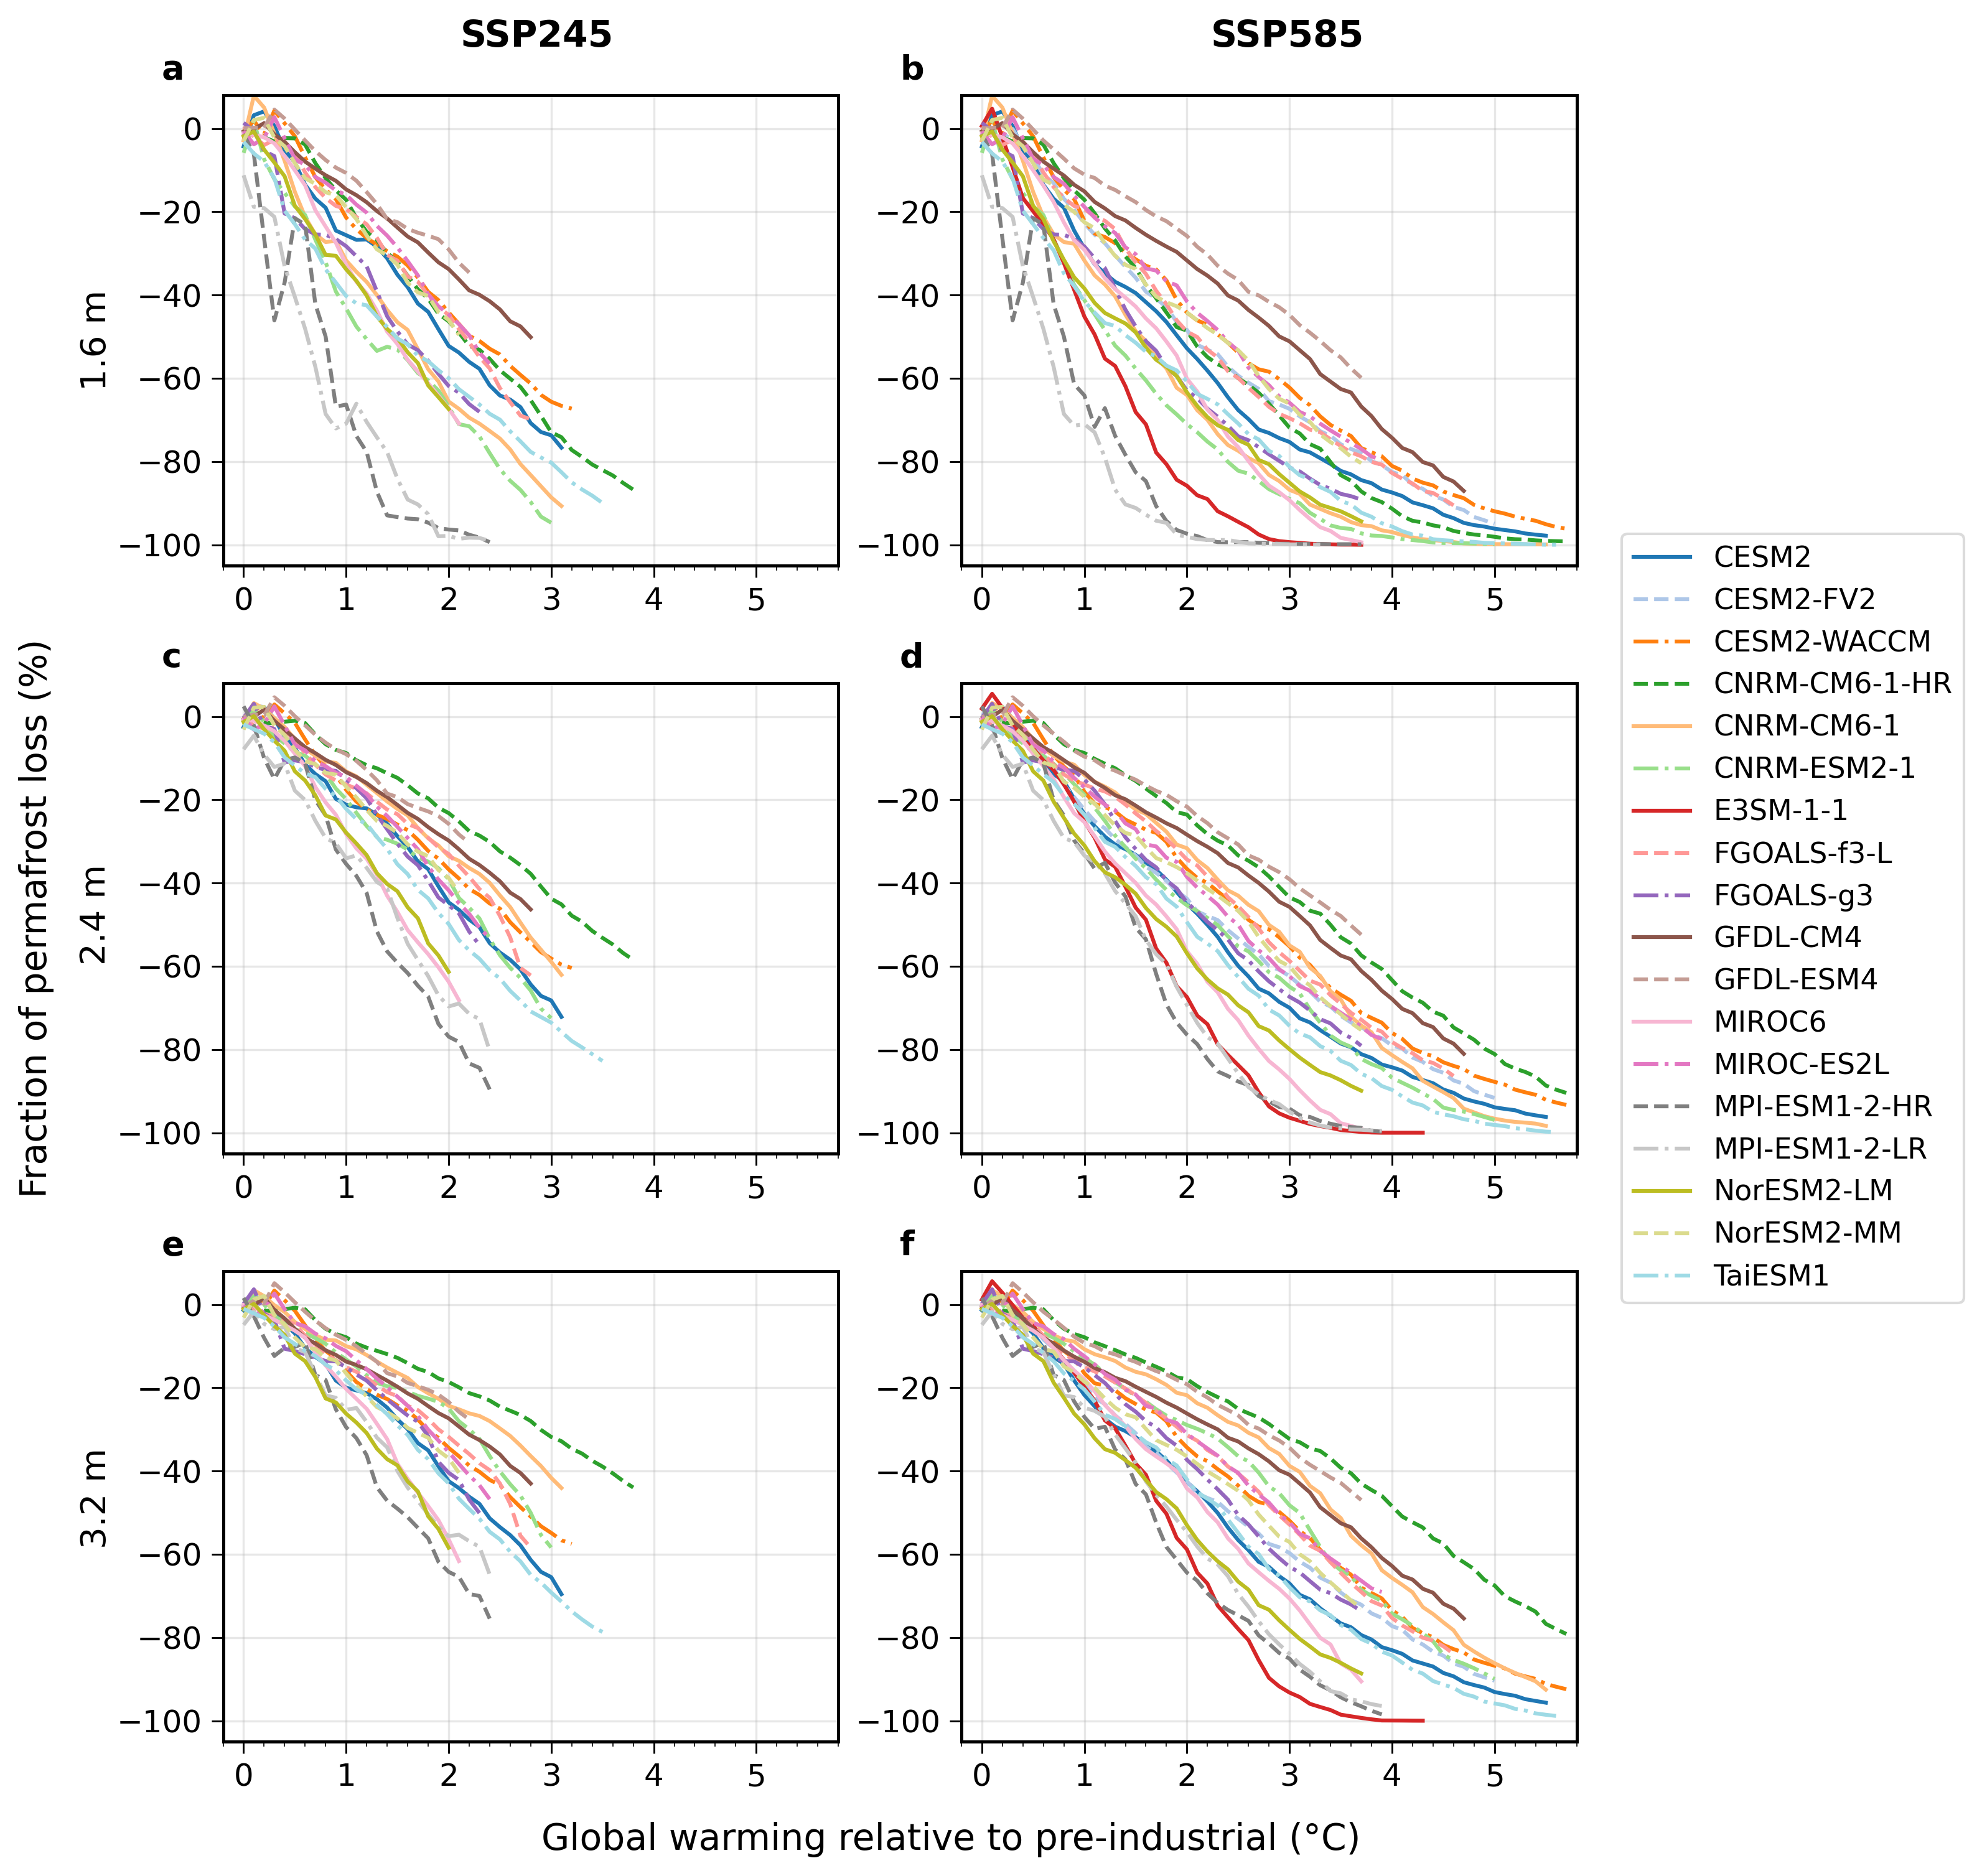

In [21]:
fig, axs = plt.subplots(figsize=(10, 10.5), nrows=3, ncols=2, dpi=300, 
                        gridspec_kw={'hspace': 0.25, 'wspace': 0.2}, facecolor='white')

# Create SSP245 plots (left column)
create_plots(axs[:,0], 0,models_245, '245')

# Create SSP585 plots (right column)
create_plots(axs[:,1], 1,models_585, '585')

# Add depth labels to the left of the first column
for i, depth in enumerate(depths):
    if i==0:
        fig.text(0.042, 0.795 , f"{int(depth[:-2])/100} m", 
            ha='center', va='center', fontsize=13.5, rotation=90)
    elif i==1:
        fig.text(0.042, 0.502 , f"{int(depth[:-2])/100} m", 
            ha='center', va='center', fontsize=13.5, rotation=90)
    else:
        fig.text(0.042, 0.204 , f"{int(depth[:-2])/100} m", 
            ha='center', va='center', fontsize=13.5, rotation=90)

# Add "Fraction of permafrost loss" label on the far left center
fig.text(0.01, 0.5, 'Fraction of permafrost loss (%)', 
         ha='center', va='center', fontsize=14, rotation=90)

# Add "Global warming relative to pre-industrial" label at bottom center
fig.text(0.5, 0.03, 'Global warming relative to pre-industrial (°C)', 
         ha='center', va='center', fontsize=14)

# Remove individual y-axis labels from subplots since we have the global label
for ax in axs.flat:
    ax.set_ylabel('')
    ax.set_xlabel('')

# Add scenario labels at top of each column
fig.text(0.278, 0.95, 'SSP245', ha='center', va='center', fontsize=14, weight='bold')
fig.text(0.68, 0.95, 'SSP585', ha='center', va='center', fontsize=14, weight='bold')

# Create unified legend using all models (from 585 scenario since it has more models)
legend_handles = []
for model in models_585:
    style = model_styles[model]
    handle = plt.Line2D([], [], color=style['color'], linestyle=style['linestyle'], label=model)
    legend_handles.append(handle)

fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.05, 0.5), 
           edgecolor='lightgrey', fontsize=11)

plt.subplots_adjust(left=0.11, right=0.835, top=0.92, bottom=0.08)
plt.show()

In [22]:
fig.savefig("../Figures/FigureS2.png", bbox_inches='tight',dpi=300)